<a href="https://colab.research.google.com/github/Ashish-Abraham/LLM-Boilerplate/blob/main/GPTFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

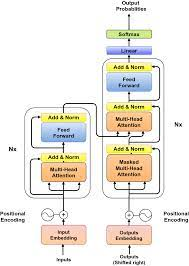

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_dim):
        super().__init__()
        self.key = nn.Linear(embed_dim, attention_dim, bias=False)
        self.query = nn.Linear(embed_dim, attention_dim, bias=False)
        self.value = nn.Linear(embed_dim, attention_dim, bias=False)

    def forward(self, x):
        B, T, _ = x.size()
        """
        [
            [write vector],
            [me vector],
            [a vector],
            [poem vector],
        ]
        """

        k = self.key(x)   # (B, T, A)
        q = self.query(x) # (B, T, A)
        v = self.value(x) # (B, T, A)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)

        # Causal mask (future positions masked)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-1e10'))

        attn = scores.softmax(dim=-1)  # (B, T, T)

        return attn @ v  # (B, T, A)


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, attention_dim):
        super().__init__()
        self.head_size = attention_dim//num_heads
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(SelfAttention(embed_dim, self.head_size))

    def forward(self,x):
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head(x)) #B x T x A//num_heads
        concatenated = torch.cat(head_outputs, dim = 2)
        return concatenated


In [22]:
class FeedForward(nn.Module):
    def __init__(self,attention_dim):
        super().__init__()
        self.up = nn.Linear(attention_dim,attention_dim*8)
        self.relu = nn.ReLU()
        self.down = nn.Linear(attention_dim*8,attention_dim)
        self.dropout2 = nn.Dropout(0.3)
    def forward(self,x):
        return self.dropout2(self.down(self.relu(self.up(x))))


In [23]:
class Decoder(nn.Module):
    def __init__(self,num_heads,embed_dim,attention_dim):
        super().__init__()
        self.masked_multihead = MultiHeadAttention(num_heads, embed_dim, attention_dim)
        self.feed_forward = FeedForward(attention_dim)
        self.n1 = nn.LayerNorm(attention_dim)
        self.n2 = nn.LayerNorm(attention_dim)
    def forward(self,x):
        e = self.masked_multihead(self.n1(x))
        e =  e + x
        e = self.feed_forward(self.n2(e))
        return e



In [24]:
class GPT(nn.Module):
    def __init__(self, num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, attention_dim)
        self.positional_embedding = nn.Embedding(context_length, attention_dim)

        self.decoders = nn.ModuleList([
            Decoder(num_heads, attention_dim, attention_dim) for _ in range(num_blocks)
        ])

        self.exit_norm = nn.LayerNorm(attention_dim)
        self.linear = nn.Linear(attention_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embedding(context)
        context_len = context.shape[1]
        position = torch.arange(context_len, device=context.device).unsqueeze(0)
        position_embeddings = self.positional_embedding(position)

        e = embeddings + position_embeddings

        for decoder in self.decoders:
            e = decoder(e)

        return self.linear(self.exit_norm(e))


In [25]:
int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = float('-inf')
    return out


def generate(model, new_chars, context, context_length, int_to_char, temperature=1.0, top_k=None):
    res = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)
        res.append(int_to_char[next_token.item()])

    return ''.join(res)




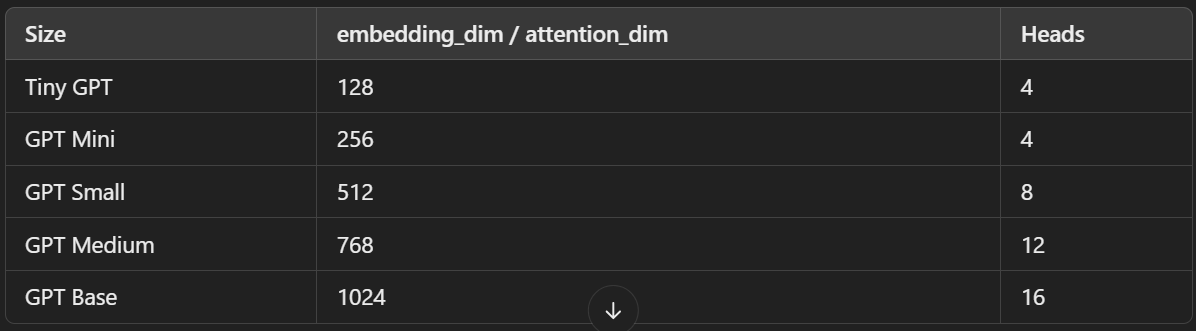

In [26]:
vocab_size = 104             # Number of tokens in your vocabulary
context_length = 128         # Maximum sequence length (tokens)
embed_dim = 256              # Token embedding size
attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
num_heads = 4                # Number of attention heads (must divide attention_dim)
num_blocks = 6               # Number of decoder blocks (layers)
num_words = 5000              # Number of new tokens to generate (optional tuning)

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length).to(device)
model.eval()

GPT(
  (embedding): Embedding(104, 256)
  (positional_embedding): Embedding(128, 256)
  (decoders): ModuleList(
    (0-5): 6 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x SelfAttention(
            (key): Linear(in_features=256, out_features=64, bias=False)
            (query): Linear(in_features=256, out_features=64, bias=False)
            (value): Linear(in_features=256, out_features=64, bias=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=256, out_features=2048, bias=True)
        (relu): ReLU()
        (down): Linear(in_features=2048, out_features=256, bias=True)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
      (n1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=256, ou

In [27]:
# generate(model,num_words,context,context_length,int_to_char)

# Train

In [28]:
!pip install datasets

In [29]:
from datasets import load_dataset

ds = load_dataset("huggingartists/coldplay")
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 432
    })
})

In [30]:
for row in ds['train']:
    print(row['text'])

Ive been reading books of old
The legends and the myths
Achilles and his gold
Hercules and his gifts
Spider-Mans control
And Batman with his fists
And clearly I dont see myself upon that list
But she said, where dyou wanna go?
How much you wanna risk?
Im not looking for somebody
With some superhuman gifts
Some superhero
Some fairytale bliss
Just something I can turn to
Somebody I can kiss
I want something just like this
Doo-doo-doo, doo-doo-doo
Doo-doo-doo, doo, doo
Doo-doo-doo, doo-doo-doo
Oh, I want something just like this
Doo-doo-doo, doo-doo-doo
Doo-doo-doo, doo, doo
Doo-doo-doo, doo-doo-doo
Oh, I want something just like this
I want something just like this
Ive been reading books of old
The legends and the myths
The testaments they told
The moon and its eclipse
And Superman unrolls
A suit before he lifts
But Im not the kind of person that it fits
She said, where dyou wanna go?
How much you wanna risk?
Im not looking for somebody
With some superhuman gifts
Some superhero
Some fair

In [31]:
import re
# Select subsets
train_subset = ds["train"].select(range(352))
test_subset = ds["train"].select(range(352, 432))

# Extract and clean lyrics
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Process training lyrics
train_lyrics = [keep_english_only(row["text"]) for row in train_subset]
joined_train_lyrics = '\n'.join(train_lyrics)

# Process test lyrics
test_lyrics = [keep_english_only(row["text"]) for row in test_subset]
joined_test_lyrics = '\n'.join(test_lyrics)

full_lyrics = joined_train_lyrics + '\n' + joined_test_lyrics



In [32]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 432
    })
})

In [33]:
characters = list(set(full_lyrics))
len(characters)

83

## Tokenizer

In [34]:
int_to_char = {}
for i, char in enumerate(characters):
    int_to_char[i] = char

char_to_int = {}

for value, char  in int_to_char.items():
    char_to_int[char] = value

print(int_to_char,char_to_int,end="\t")

{0: 'd', 1: '7', 2: 'E', 3: 'v', 4: 'g', 5: 'r', 6: 'D', 7: ',', 8: 's', 9: '3', 10: 'V', 11: 'J', 12: 'F', 13: ' ', 14: '2', 15: 'L', 16: 'a', 17: 'j', 18: 'X', 19: 'T', 20: '(', 21: 'm', 22: 'R', 23: '5', 24: '?', 25: '}', 26: '_', 27: 'c', 28: '8', 29: '6', 30: 'U', 31: 'Q', 32: '{', 33: 't', 34: 'W', 35: ';', 36: '/', 37: '4', 38: 'i', 39: 'u', 40: '1', 41: 'h', 42: 'C', 43: '-', 44: '&', 45: 'x', 46: 'G', 47: '$', 48: 'q', 49: '.', 50: '%', 51: 'w', 52: '9', 53: '#', 54: 'o', 55: ':', 56: 'n', 57: '+', 58: 'K', 59: '\n', 60: 'f', 61: 'Z', 62: 'b', 63: 'l', 64: 'e', 65: 'z', 66: 'I', 67: 'p', 68: 'P', 69: 'N', 70: 'M', 71: '@', 72: '0', 73: 'y', 74: 'Y', 75: 'A', 76: 'S', 77: 'k', 78: 'B', 79: 'O', 80: '!', 81: ')', 82: 'H'} {'d': 0, '7': 1, 'E': 2, 'v': 3, 'g': 4, 'r': 5, 'D': 6, ',': 7, 's': 8, '3': 9, 'V': 10, 'J': 11, 'F': 12, ' ': 13, '2': 14, 'L': 15, 'a': 16, 'j': 17, 'X': 18, 'T': 19, '(': 20, 'm': 21, 'R': 22, '5': 23, '?': 24, '}': 25, '_': 26, 'c': 27, '8': 28, '6': 29, 

In [35]:


encoded_train = [char_to_int[c] for c in joined_train_lyrics if c in char_to_int]

encoded_test = [char_to_int[c] for c in joined_test_lyrics if c in char_to_int]

print(len(encoded_train),len(encoded_test))

320566 83790


In [36]:

# context_length=3
# encoded= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

def create_dataset(encoded, context_length=128):
  inputs, targets = [], []
  for i in range(len(encoded) - context_length):
    inputs.append(encoded[i:i+context_length])
    targets.append(encoded[i+1:i+context_length+1])
  return torch.tensor(inputs), torch.tensor(targets)

train_inputs, train_targets = create_dataset(encoded_train)
test_inputs, test_targets = create_dataset(encoded_test)



In [39]:
from torch.utils.data import TensorDataset, DataLoader


def train(model):
  vocab_size = len(char_to_int)
  context_length = 128
  embed_dim = 128
  attention_dim = 128
  num_heads = 4
  num_blocks = 6
  epochs = 40
  lr = 0.001
  patience = 3
  batch_size = 32


  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
  best_loss = float('inf')
  patience_counter = 0
  losses, accuracies = [],[]

  train_loader = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=batch_size)


  for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      pred = model(X)
      pred_flat = pred.view(-1, vocab_size)
      y_flat = y.view(-1)
      loss = loss_func(pred_flat, y_flat)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      predictions = pred_flat.argmax(dim=1)
      correct += (predictions == y_flat).sum().item()
      total += y_flat.size(0)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)
    # Evaluation
    model.eval()
    eval_loss = 0
    with torch.no_grad():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        pred_flat = pred.view(-1, vocab_size)
        y_flat = y.view(-1)
        loss = loss_func(pred_flat, y_flat)
        eval_loss += loss.item()
    eval_loss /= len(test_loader)
    print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}, Eval Loss={eval_loss:.4f}")
    if avg_loss < best_loss:
      best_loss = avg_loss
      patience_counter = 0
      best_model_state = model.state_dict()
    else:
      patience_counter += 1
      if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break
  return model, epoch+1, losses, accuracies


In [ ]:
vocab_size = 83
context_length = 128
embed_dim = 128
attention_dim = 128
num_heads = 4
num_blocks = 6

model = GPT(num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length).to(device)
#model.load_state_dict(torch.load("/content/trained_model-128-85.pth", weights_only=False))

model,epochs,losses,accuracies = train(model)
# Save the trained model
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


from google.colab import files
files.download('trained_model.pth')

Epoch 1: Train Loss=2.9923, Accuracy=0.1847, Eval Loss=2.9766
Epoch 2: Train Loss=2.5018, Accuracy=0.2728, Eval Loss=2.1993
Epoch 3: Train Loss=1.7594, Accuracy=0.4696, Eval Loss=1.7817
Epoch 4: Train Loss=1.3911, Accuracy=0.5753, Eval Loss=1.6761
Epoch 5: Train Loss=1.2424, Accuracy=0.6198, Eval Loss=1.6222
Epoch 6: Train Loss=1.1552, Accuracy=0.6459, Eval Loss=1.5853
Epoch 7: Train Loss=1.0940, Accuracy=0.6643, Eval Loss=1.5758
Epoch 8: Train Loss=1.0484, Accuracy=0.6778, Eval Loss=1.5480


### Cross Entropy
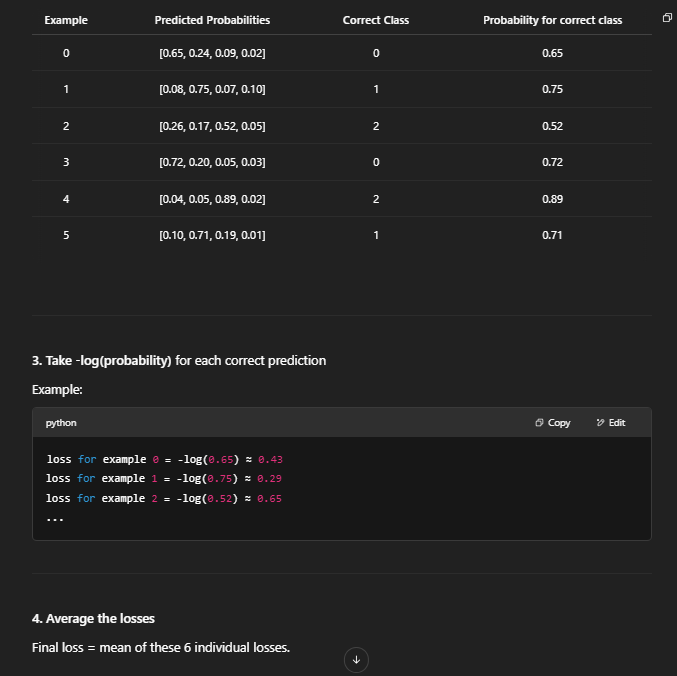

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()